In [26]:
import logging
L = logging.getLogger(__name__)
from pathlib import Path
import pickle

import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.nn.functional import pad
from tqdm.auto import tqdm

In [27]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(str(Path(".").resolve().parent.parent))

from berp.datasets import BerpDataset, NestedBerpDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
story_name = "old-man-and-the-sea"
subject = 15
run = 10

# aligned_words = "word.csv"
# aligned_phonemes = "phoneme.csv"
aligned_words = f"../../workflow/heilbron2022/data/aligned/distilgpt2/{story_name}/word.csv"
aligned_phonemes = f"../../workflow/heilbron2022/data/aligned/distilgpt2/{story_name}/phoneme.csv"

# stimulus = "old-man-and-the-sea/run2.pkl"
stimulus = f"../../workflow/heilbron2022/data/stimulus/distilgpt2/{story_name}/run{run}.pkl"

run_Xy = f"../../workflow/heilbron2022/data/run_Xy/{story_name}/sub{subject}/run{run}.h5"
# run_Xy = "/home/jgauthie/om2/others/heilbron2022/notebooks/exported/Xy/words_proba/sub1/run2.h5"

target_sample_rate = 128
output_path = f"{story_name}.sub{subject}.run{run}.pkl"

## Load and process natural language stimulus

In [29]:
with Path(stimulus).open("rb") as f:
    story_stim = pickle.load(f)
    
assert story_stim.name == f"{story_name}/run{run}"

FileNotFoundError: [Errno 2] No such file or directory: '../../workflow/heilbron2022/data/stimulus/distilgpt2/old-man-and-the-sea/run10.pkl'

In [5]:
# Variable onset features are simply a variable onset intercept,
# word features and word surprisals.
X_variable = torch.concat(
    [torch.ones_like(story_stim.word_surprisals).unsqueeze(1),
     story_stim.word_features,
     story_stim.word_surprisals.unsqueeze(1)],
    dim=1)
variable_feature_names = ["recognition_onset"] + story_stim.word_feature_names + ["word_surprisal"]

assert X_variable.shape[1] == len(variable_feature_names)

In [6]:
variable_feature_names

['recognition_onset', 'word_frequency', 'word_surprisal']

## Load aligned word/phoneme presentation data

In [7]:
word_aligned_df = pd.read_csv(aligned_words, index_col=[0, 1]).loc[run].reset_index()
phoneme_aligned_df = pd.read_csv(aligned_phonemes, index_col=[0, 1]).loc[run].reset_index()
word_aligned_df

,word_idx,word,onset,offset,token_idx
0,0,JUST,1.13,1.38,6032
1,1,THEN,1.38,1.65,6033
2,2,HE,1.65,1.77,6034
3,3,SAW,1.77,2.02,6035
4,4,A,2.02,2.05,6036
...,...,...,...,...,...
627,593,BEHIND,190.62,191.01,6726
628,594,IT,191.01,191.12,6727
629,595,IN,191.12,191.20,6728
630,596,THE,191.20,191.28,6729


### Check for words missing in stimulus

{14, 62, 120, 145, 172, 226, 281, 310, 338, 366, 425, 483, 511, 542, 588}

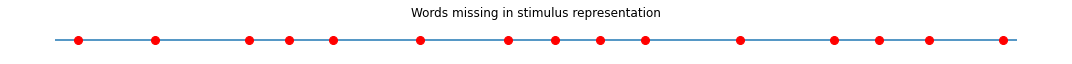

In [8]:
# Not all words in the presentation will be retained in the stimulus: words which
# ended up at the start of an input time series to the model were dropped, because
# the model didn't have those values as targets.
#
# By the above logic, the missing words will likely be distributed roughly evenly
# throughout the stimulus.
words_missing_in_stimulus = set(word_aligned_df.word_idx) - set(story_stim.word_ids.numpy())

plt.figure(figsize=(15, 1))
plt.hlines(0, 0, story_stim.word_ids.max())
plt.plot(list(words_missing_in_stimulus), np.zeros(len(words_missing_in_stimulus)), 'ro', ms=8, mfc='r')
plt.axis('off')
plt.title("Words missing in stimulus representation")
plt.tight_layout()

words_missing_in_stimulus

In [9]:
assert 0 == len(set(story_stim.word_ids.numpy()) - set(word_aligned_df.word_idx)), \
    "Stim words are present which are missing from the aligned data!"

## Load design matrix data

In [10]:
with h5py.File(run_Xy) as f:
    assert subject == f.attrs["subject"]
    assert run == f.attrs["run"]
    
    X = f["X"][()]
    y = f["y"][()].T
    
    sensor_names = f.attrs["ch_names"].tolist()
    ts_feature_names = f.attrs["feature_names"].tolist()
    sfreq = f.attrs["sfreq"]

In [11]:
assert X.shape[0] == y.shape[0]
assert X.shape[1] == len(ts_feature_names)
assert y.shape[1] == len(sensor_names)

### Add intercept feature to time series

In [12]:
X = np.hstack([np.ones((X.shape[0], 1)), X])
ts_feature_names = ['intercept'] + ts_feature_names

### Remove surprisal+frequency data

In [13]:
drop_ts_features = ["all_words_lexical_surprise", "all_words_unigram_surprise"]
keep_ts_feature_idxs = [i for i, name in enumerate(ts_feature_names) if name not in drop_ts_features]

X = X[:, keep_ts_feature_idxs]
ts_feature_names = [name for i, name in enumerate(ts_feature_names) if i in keep_ts_feature_idxs]
ts_feature_names

['intercept',
 'all_words_onset',
 'all_phons_onset',
 'all_phons_pitch',
 'all_phons_env_var',
 'all_phons_surprisals',
 'all_phons_sg1',
 'all_phons_sg2',
 'all_phons_sg3',
 'all_phons_sg4',
 'all_phons_sg5',
 'all_phons_sg6',
 'all_phons_sg7',
 'all_phons_sg8']

### Check agreement between aligned word data and time series data

Verify that the word onsets as represented in the design matrix agree with the word onset data as given in the aligned annotation.

In [14]:
word_onset_idx = ts_feature_names.index("all_words_onset")
X_onset_times = X[:, word_onset_idx].nonzero()[0] / sfreq
X_onset_times[:10]

array([1.1328125, 1.3828125, 1.6484375, 1.7734375, 2.0234375, 2.046875 ,
       2.28125  , 2.421875 , 2.640625 , 3.0390625])

In [15]:
aligned_onset_times = word_aligned_df.groupby("word_idx").onset.min()
aligned_onset_times.values[:10]

array([1.13, 1.38, 1.65, 1.77, 2.02, 2.05, 2.28, 2.42, 2.64, 3.04])

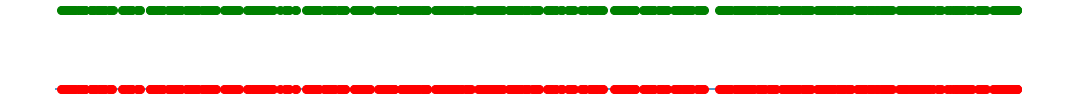

In [16]:
plt.figure(figsize=(15, 1.5))
plt.hlines(0, 0, X_onset_times.max())
plt.plot(X_onset_times, np.zeros(len(X_onset_times)), 'ro', ms=8, mfc='r')
plt.plot(aligned_onset_times, np.ones(len(aligned_onset_times)), 'go', ms=8)
plt.axis('off')
plt.tight_layout()

In [18]:
len(X_onset_times), len(aligned_onset_times)

(598, 596)

In [19]:
set(X_onset_times.round(2)) - set(aligned_onset_times)

{61.72, 181.08}

In [24]:
word_aligned_df[word_aligned_df.onset.between(60, 62)]

,word_idx,word,onset,offset,token_idx
196,183,THE,60.06,60.17,6254
197,184,SIDE,60.17,60.64,6255
198,185,AND,60.64,60.78,6256
199,186,THEN,60.78,60.96,6257
200,187,MADE,60.96,61.12,6258
201,188,IT,61.12,61.23,6259
202,189,FAST,61.23,61.63,6260
203,190,TO,61.63,61.72,6261
204,192,RING,61.80,62.03,6263


In [25]:
word_aligned_df[word_aligned_df.onset.between(180, 182)]

,word_idx,word,onset,offset,token_idx
594,562,OF,180.12,180.26,6689
595,563,WAR,180.26,180.69,6691
596,564,FLOATING,180.69,181.08,6692
597,566,BESIDE,181.39,181.78,6694
598,567,THE,181.78,181.85,6695
599,568,BOAT,181.85,182.22,6696


In [17]:
assert len(X_onset_times) == len(aligned_onset_times)

AssertionError: 

In [48]:
# NB aligned annotation only has precision to 2 places, so we'll have to round.
np.testing.assert_allclose(X_onset_times.round(2), aligned_onset_times)

In [49]:
# # Find overlap
# array1 = X_onset_times
# array2 = word_aligned_df.onset.unique()
# import itertools
# from tqdm.auto import trange
# matches = []
# no_match = []
# for i0 in trange(array1.shape[0]):
#     for i1 in range(array2.shape[0]):
#         if np.isclose(array1[i0], array2[i1], atol=1e-1):
#             matches.append((i0, i1))
#             break
#     else:
#         no_match.append(i0)

In [50]:
# len(no_match)

In [51]:
# len(matches)

In [55]:
# plt.figure(figsize=(15, 2))
# plt.hlines(0, 0, X_onset_times.max())
# mask = np.zeros(len(X_onset_times), dtype=bool)
# mask[no_match] = True
# plt.plot(X_onset_times[mask], np.zeros(mask.sum()), 'ro', ms=8, mfc='r', alpha=0.3)
# plt.plot(X_onset_times[~mask], np.zeros((~mask).sum()), 'ro', ms=8, mfc='g', alpha=0.3)
# # plt.plot(word_aligned_df.onset.values, np.ones(len(word_aligned_df)), 'go', ms=8)
# plt.axis('off')
# plt.tight_layout()

## Load signal data

In [56]:
min_time, max_time = 0, len(X) / sfreq
max_time

184.203125

In [59]:
# Check compatibility with alignment data.
assert min_time <= word_aligned_df.onset.min()
assert min_time <= phoneme_aligned_df.onset.min()
assert max_time >= word_aligned_df.offset.max()
assert max_time >= phoneme_aligned_df.offset.max()

## Replace onset features

Even though we already checked that the two annotations agree, we're going to insert our own aligned to the sample rate, just to make sure the setup is absolutely perfect.

In [61]:
word_aligned_df["onset"] = (word_aligned_df["onset"] * target_sample_rate).round() / target_sample_rate
word_aligned_df["offset"] = (word_aligned_df["offset"] * target_sample_rate).round() / target_sample_rate
phoneme_aligned_df["onset"] = (phoneme_aligned_df["onset"] * target_sample_rate).round() / target_sample_rate
phoneme_aligned_df["offset"] = (phoneme_aligned_df["offset"] * target_sample_rate).round() / target_sample_rate
phoneme_aligned_df["offset_word"] = (phoneme_aligned_df["offset_word"] * target_sample_rate).round() / target_sample_rate

In [62]:
word_onset_samples = (word_aligned_df["onset"] * target_sample_rate).astype(int)
phoneme_onset_samples = (phoneme_aligned_df["onset"] * target_sample_rate).astype(int)

# Drop words+phonemes which extend past the end of the time series.
word_onset_samples = word_onset_samples[word_onset_samples < len(X)]
phoneme_onset_samples = phoneme_onset_samples[phoneme_onset_samples < len(X)]

word_onset_features = np.zeros((len(X), 1))
phoneme_onset_features = np.zeros((len(X), 1))
word_onset_features[word_onset_samples] = 1
phoneme_onset_features[phoneme_onset_samples] = 1

X = np.concatenate((X, word_onset_features, phoneme_onset_features), axis=1)
ts_feature_names += ["word_onset", "phoneme_onset"]
assert X.shape[1] == len(ts_feature_names)

In [63]:
# Remove Heilbron onset data.
remove_onset_features = ["all_words_onset", "c_words_onset", "all_phons_onset"]
for feat in remove_onset_features:
    try:
        feat_idx = ts_feature_names.index(feat)
    except ValueError:
        L.warning(f"No feature {feat}")
    else:
        X = np.delete(X, feat_idx, axis=1)
        ts_feature_names = ts_feature_names[:feat_idx] + ts_feature_names[feat_idx + 1:]
        
assert X.shape[1] == len(ts_feature_names)

No feature c_words_onset


## Produce BerpDataset representations

In [65]:
# Now produce onset information from canonical aligned data.
word_onsets = word_aligned_df.groupby("word_idx").onset.min().to_dict()
word_onsets = torch.tensor([word_onsets.get(word_id.item(), np.nan)
                            for word_id in story_stim.word_ids])

word_offsets = word_aligned_df.groupby("word_idx").offset.max().to_dict()
word_offsets = torch.tensor([word_offsets.get(word_id.item(), np.nan)
                             for word_id in story_stim.word_ids])

In [66]:
# Compute phoneme onsets relative to word onset.
phoneme_onsets = phoneme_aligned_df.groupby("word_idx") \
    .apply(lambda xs: list(xs.onset - xs.onset.min())).to_dict()
phoneme_onsets = [torch.tensor(phoneme_onsets.get(word_id.item(), [np.nan]))
                  for word_id in story_stim.word_ids]

In [68]:
max_num_phonemes = max(len(onsets) for onsets in phoneme_onsets)

# Sanity check: max_num_phonemes as computed from aligned data should
# match that produced earlier by the natural language stimulus processor
assert max_num_phonemes == story_stim.max_n_phonemes, \
    "%d %d" % (max_num_phonemes, story_stim.max_n_phonemes)

In [69]:
# Pad phoneme onset information
phoneme_onsets = torch.stack([
    pad(onsets, (0, max_num_phonemes - len(onsets)), value=0.)
    if len(onsets) < max_num_phonemes
    else onsets
    for onsets in phoneme_onsets
])

In [70]:
dataset = BerpDataset(
    name=f"{story_name}/sub{subject}/run{run}",
    stimulus_name=story_stim.name,
    sample_rate=sfreq,
    
    phonemes=story_stim.phonemes,
    
    word_onsets=word_onsets,
    word_offsets=word_offsets,
    phoneme_onsets=phoneme_onsets,
    
    X_ts=X,
    ts_feature_names=ts_feature_names,
    
    X_variable=X_variable,
    variable_feature_names=variable_feature_names,
    
    Y=y,
    sensor_names=sensor_names,
)

In [71]:
with Path(output_path).open("wb") as f:
    pickle.dump(dataset, f)